In [ ]:
"""
Volatility Surface Under Black-Scholes Framework
================================================

A comprehensive implementation demonstrating:
1. Black-Scholes pricing (forward problem)
2. Implied volatility extraction (inverse problem via bisection)
3. Volatility surface construction and interpolation
4. Visualization of smile, skew, and term structure

"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.interpolate import RectBivariateSpline
import pandas as pd

In [2]:
# ============================================================================
# PART 1: BLACK-SCHOLES PRICING ENGINE (FORWARD PROBLEM)
# ============================================================================

def black_scholes_call(S0, K, T, r, sigma, q=0.0):
    """
    European call option pricing under Black-Scholes framework.
    
    Parameters:
    -----------
    S0 : float
        Current spot price
    K : float
        Strike price
    T : float
        Time to maturity (years)
    r : float
        Risk-free interest rate
    sigma : float
        Volatility (annualized)
    q : float, optional
        Dividend yield (default: 0)
    
    Returns:
    --------
    float : Call option price
    """
    
    # Guard against edge cases
    if T <= 0 or sigma <= 0:
        return max(S0 - K, 0)
    
    # Calculate d1 and d2
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Apply Black-Scholes formula
    call_price = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return call_price


def black_scholes_put(S0, K, T, r, sigma, q=0.0):
    """European put option pricing under Black-Scholes."""
    if T <= 0 or sigma <= 0:
        return max(K - S0, 0)
    
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * np.exp(-q * T) * norm.cdf(-d1)
    
    return put_price

In [11]:
# ============================================================================
# PART 2: SYNTHETIC MARKET GENERATION
# ============================================================================

def sigma_true(S0, K, T, base=0.15, smile_strength=0.1):
    """
    Generate synthetic "true" volatility with market structure.
    
    Includes:
    - Volatility smile (curvature around ATM)
    - Volatility skew (tilt towards low strikes)
    - Term structure (decays with maturity)
    
    Parameters:
    -----------
    S0 : float
        Spot price
    K : float
        Strike price
    T : float
        Time to maturity
    base : float
        Base volatility
    smile_strength : float
        Strength of smile effect
    
    Returns:
    --------
    float : Volatility at (K, T)
    """
    
    # Moneyness: ratio of strike to spot
    moneyness = K / S0
    
    # Smile: symmetric curvature, stronger at short maturities
    smile = smile_strength * (1 - 1.0 / (0.1 + abs(moneyness - 1.0))) * np.exp(-1.5 * T)
    
    # Skew: downside tilt (low strikes have higher vol)
    skew = -0.10 * (moneyness - 1.0) * np.exp(-0.5 * T)
    
    # Term structure: short-term premium that decays
    term = 0.03 * np.exp(-2.0 * T)
    
    # Ensure volatility stays positive and reasonable
    sigma = base + smile + skew + term
    return np.clip(sigma, 0.05, 0.80)


def generate_synthetic_market(S0=100, strikes=None, maturities=None, r=0.05):
    """
    Generate synthetic option market with "true" volatility.
    
    Parameters:
    -----------
    S0 : float
        Current spot price
    strikes : array-like
        Strike prices
    maturities : array-like
        Times to maturity (years)
    r : float
        Risk-free rate
    
    Returns:
    --------
    prices : 2D array
        Synthetic call prices (strikes Ã— maturities)
    sigmas_true : 2D array
        True volatilities used to generate prices
    """
    
    if strikes is None:
        strikes = np.linspace(S0 * 0.70, S0 * 1.30, 11)
    if maturities is None:
        maturities = np.array([0.1, 0.25, 0.5, 1.0, 2.0])
    
    # Initialize grids
    prices = np.zeros((len(strikes), len(maturities)))
    sigmas_true = np.zeros((len(strikes), len(maturities)))
    
    # Generate prices using true volatility
    for i, K in enumerate(strikes):
        for j, T in enumerate(maturities):
            sig = sigma_true(S0, K, T)
            sigmas_true[i, j] = sig
            prices[i, j] = black_scholes_call(S0, K, T, r, sig)
    
    return prices, sigmas_true, strikes, maturities

In [12]:
# ============================================================================
# PART 3: INVERSE SOLVER - IMPLIED VOLATILITY (BISECTION METHOD)
# ============================================================================

def implied_volatility_bisection(market_price, S0, K, T, r, q=0.0, 
                                 tol=1e-6, max_iter=100):
    """
    Extract implied volatility from market price using bisection method.
    
    This solves: f(Ïƒ) = BS_price(Ïƒ) - market_price = 0
    
    Parameters:
    -----------
    market_price : float
        Observed option market price
    S0 : float
        Spot price
    K : float
        Strike price
    T : float
        Time to maturity
    r : float
        Risk-free rate
    q : float
        Dividend yield
    tol : float
        Convergence tolerance
    max_iter : int
        Maximum iterations
    
    Returns:
    --------
    sigma : float
        Implied volatility
    """
    
    # Define objective function
    def f(sigma):
        return black_scholes_call(S0, K, T, r, sigma, q) - market_price
    
    # Initialize bracket [lo, hi]
    lo, hi = 0.001, 3.0
    f_lo = f(lo)
    f_hi = f(hi)
    
    # Expand hi if necessary to bracket the root
    max_expansions = 20
    expansions = 0
    while f_lo * f_hi > 0 and expansions < max_expansions:
        hi *= 1.5
        f_hi = f(hi)
        expansions += 1
    
    if f_lo * f_hi > 0:
        # Could not bracket root - return best estimate
        return hi if abs(f_hi) < abs(f_lo) else lo
    
    # Bisection loop
    for iteration in range(max_iter):
        mid = 0.5 * (lo + hi)
        f_mid = f(mid)
        
        # Check convergence
        if abs(f_mid) < tol:
            return mid
        
        # Update bracket
        if f_lo * f_mid <= 0:
            hi = mid
            f_hi = f_mid
        else:
            lo = mid
            f_lo = f_mid
    
    return 0.5 * (lo + hi)


def extract_implied_volatility_grid(prices, S0, strikes, maturities, r):
    """
    Extract implied volatility for entire grid of options.
    
    Parameters:
    -----------
    prices : 2D array
        Market prices (strikes Ã— maturities)
    S0 : float
        Spot price
    strikes : array
        Strike prices
    maturities : array
        Maturities
    r : float
        Risk-free rate
    
    Returns:
    --------
    iv_grid : 2D array
        Implied volatility grid
    """
    
    iv_grid = np.zeros_like(prices)
    
    for i, K in enumerate(strikes):
        for j, T in enumerate(maturities):
            # Add small noise tolerance (market prices have bid-ask spreads)
            iv = implied_volatility_bisection(prices[i, j], S0, K, T, r)
            iv_grid[i, j] = iv
    
    return iv_grid

In [13]:
# ============================================================================
# PART 4: VOLATILITY SURFACE INTERPOLATION
# ============================================================================

def fit_volatility_surface(strikes, maturities, iv_grid, S0):
    """
    Fit smooth 2D spline to implied volatility grid.
    
    Parameters:
    -----------
    strikes : array
        Strike prices
    maturities : array
        Times to maturity
    iv_grid : 2D array
        Implied volatility grid (strikes × maturities)
    S0 : float
        Spot price for moneyness calculation
    
    Returns:
    --------
    spline : scipy.interpolate.RectBivariateSpline
        Smooth surface interpolator
    moneyness : array
        Moneyness values (K/S0)
    """
    
    # Convert to moneyness
    moneyness = strikes / S0
    
    # FIX: Remove the .T - iv_grid is already (strikes, maturities)
    # RectBivariateSpline(x, y, z) expects z.shape = (len(x), len(y))
    spline = RectBivariateSpline(
        moneyness, maturities, iv_grid,  # <-- REMOVED .T here
        kx=min(3, len(moneyness) - 1),
        ky=min(3, len(maturities) - 1),
        s=1e-4
    )
    
    return spline, moneyness


In [14]:
# ============================================================================
# PART 5: VISUALIZATION FUNCTIONS
# ============================================================================

def plot_volatility_surface_3d(strikes, maturities, iv_grid, S0, title="Volatility Surface"):
    """
    Create 3D surface plot of implied volatility.
    
    Parameters:
    -----------
    strikes : array
        Strike prices
    maturities : array
        Maturities
    iv_grid : 2D array
        Implied volatility grid
    S0 : float
        Spot price
    title : str
        Plot title
    """
    
    # Create mesh grid for moneyness
    K_grid, T_grid = np.meshgrid(strikes / S0, maturities)
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(K_grid, T_grid, iv_grid.T, cmap='viridis', 
                           edgecolor='none', alpha=0.9)
    
    ax.set_xlabel('Moneyness (K/S)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Time to Maturity (years)', fontsize=11, fontweight='bold')
    ax.set_zlabel('Implied Volatility', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    
    # Add colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('IV', fontsize=10)
    
    ax.view_init(elev=25, azim=45)
    plt.tight_layout()
    
    return fig


def plot_volatility_smile(strikes, iv_grid, maturities, S0, 
                          selected_maturities=None, title="Volatility Smile"):
    """
    Plot 2D volatility smile at selected maturities.
    
    Shows how IV varies across strikes at fixed time to maturity.
    
    Parameters:
    -----------
    strikes : array
        Strike prices
    iv_grid : 2D array
        IV grid (strikes Ã— maturities)
    maturities : array
        Maturity values
    S0 : float
        Spot price
    selected_maturities : list
        Indices of maturities to plot
    title : str
        Plot title
    """
    
    if selected_maturities is None:
        selected_maturities = list(range(0, len(maturities), max(1, len(maturities)//5)))
    
    moneyness = strikes / S0
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    colors = plt.cm.cool(np.linspace(0, 1, len(selected_maturities)))
    
    for idx, T_idx in enumerate(selected_maturities):
        label = f'T = {maturities[T_idx]:.2f} years'
        ax.plot(moneyness, iv_grid[:, T_idx], 'o-', 
                linewidth=2.5, markersize=7, color=colors[idx], label=label)
    
    ax.axvline(x=1.0, color='black', linestyle='--', alpha=0.5, label='ATM')
    ax.set_xlabel('Moneyness (K/S)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Implied Volatility', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    return fig


def plot_term_structure(maturities, iv_grid, strikes, S0,
                        selected_strikes=None, title="Term Structure"):
    """
    Plot term structure showing IV evolution across maturities.
    
    Shows how IV changes over time for fixed strikes.
    
    Parameters:
    -----------
    maturities : array
        Maturity values
    iv_grid : 2D array
        IV grid (strikes Ã— maturities)
    strikes : array
        Strike prices
    S0 : float
        Spot price
    selected_strikes : list
        Indices of strikes to plot
    title : str
        Plot title
    """
    
    if selected_strikes is None:
        selected_strikes = list(range(0, len(strikes), max(1, len(strikes)//5)))
    
    moneyness = strikes / S0
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    colors = plt.cm.Spectral(np.linspace(0, 1, len(selected_strikes)))
    
    for idx, K_idx in enumerate(selected_strikes):
        moneyness_val = moneyness[K_idx]
        label = f'K/S = {moneyness_val:.2f}'
        ax.plot(maturities, iv_grid[K_idx, :], 'o-',
                linewidth=2.5, markersize=7, color=colors[idx], label=label)
    
    ax.axvline(x=maturities[0], color='red', linestyle='--', alpha=0.5, label='Short-dated')
    ax.set_xlabel('Time to Maturity (years)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Implied Volatility', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    return fig


def plot_option_prices_2d(S0, strikes, maturities, iv_grid, r, title="Option Prices by Strike"):
    """
    Plot option prices at different maturities.
    
    Parameters:
    -----------
    S0 : float
        Spot price
    strikes : array
        Strike prices
    maturities : array
        Maturities
    iv_grid : 2D array
        IV grid
    r : float
        Risk-free rate
    title : str
        Plot title
    """
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    colors = plt.cm.cool(np.linspace(0, 1, len(maturities)))
    
    for j, T in enumerate(maturities):
        prices = []
        for i, K in enumerate(strikes):
            sigma = iv_grid[i, j]
            price = black_scholes_call(S0, K, T, r, sigma)
            prices.append(price)
        
        ax.plot(strikes, prices, 'o-', linewidth=2.5, markersize=7,
                color=colors[j], label=f'T = {T:.2f} years')
    
    ax.axvline(x=S0, color='black', linestyle='--', alpha=0.5, label='Spot Price')
    ax.set_xlabel('Strike Price (K)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Call Option Price', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    return fig


def create_summary_table(strikes, maturities, iv_grid, S0):
    """
    Create DataFrame summary of volatility grid.
    
    Parameters:
    -----------
    strikes : array
        Strike prices
    maturities : array
        Maturities
    iv_grid : 2D array
        IV grid
    S0 : float
        Spot price
    
    Returns:
    --------
    df : pandas.DataFrame
        Formatted table
    """
    
    moneyness = strikes / S0
    
    data = []
    for i, (K, m) in enumerate(zip(strikes, moneyness)):
        row = {'Strike': f'{K:.1f}', 'Moneyness': f'{m:.3f}'}
        for j, T in enumerate(maturities):
            row[f'T={T:.2f}y'] = f'{iv_grid[i, j]:.2%}'
        data.append(row)
    
    df = pd.DataFrame(data)
    return df

VOLATILITY SURFACE UNDER BLACK-SCHOLES FRAMEWORK

[STEP 1] Generating Synthetic Market...
  Spot Price: 100
  Risk-free Rate: 5.00%
  Strikes: [ 70  75  80  90 100 110 120 130]
  Maturities: [0.1  0.25 0.5  1.   2.  ]

[STEP 2] Extracting Implied Volatilities (Bisection Method)...
  âœ“ Extracted 40 implied volatilities
  Repricing Error (Max): 9.89e-07
  Repricing Error (Mean): 3.22e-07

[STEP 3] Fitting Volatility Surface (2D Spline)...
  âœ“ Surface fitted successfully

[STEP 4] Summary Statistics...
  True Volatility - Mean: 8.13%, Std: 3.62%
  Implied Volatility - Mean: 9.29%, Std: 4.10%

[STEP 5] Creating Visualizations...
  âœ“ Saved: volatility_surface_3d.png
  âœ“ Saved: volatility_smile.png
  âœ“ Saved: volatility_term_structure.png
  âœ“ Saved: option_prices_2d.png

[STEP 6] Summary Table...
Strike Moneyness T=0.10y T=0.25y T=0.50y T=1.00y T=2.00y
  70.0     0.700  18.84%   9.47%  11.23%  13.88%  15.41%
  75.0     0.750  18.84%   9.47%   9.47%  12.78%  15.05%
  80.0     0.80

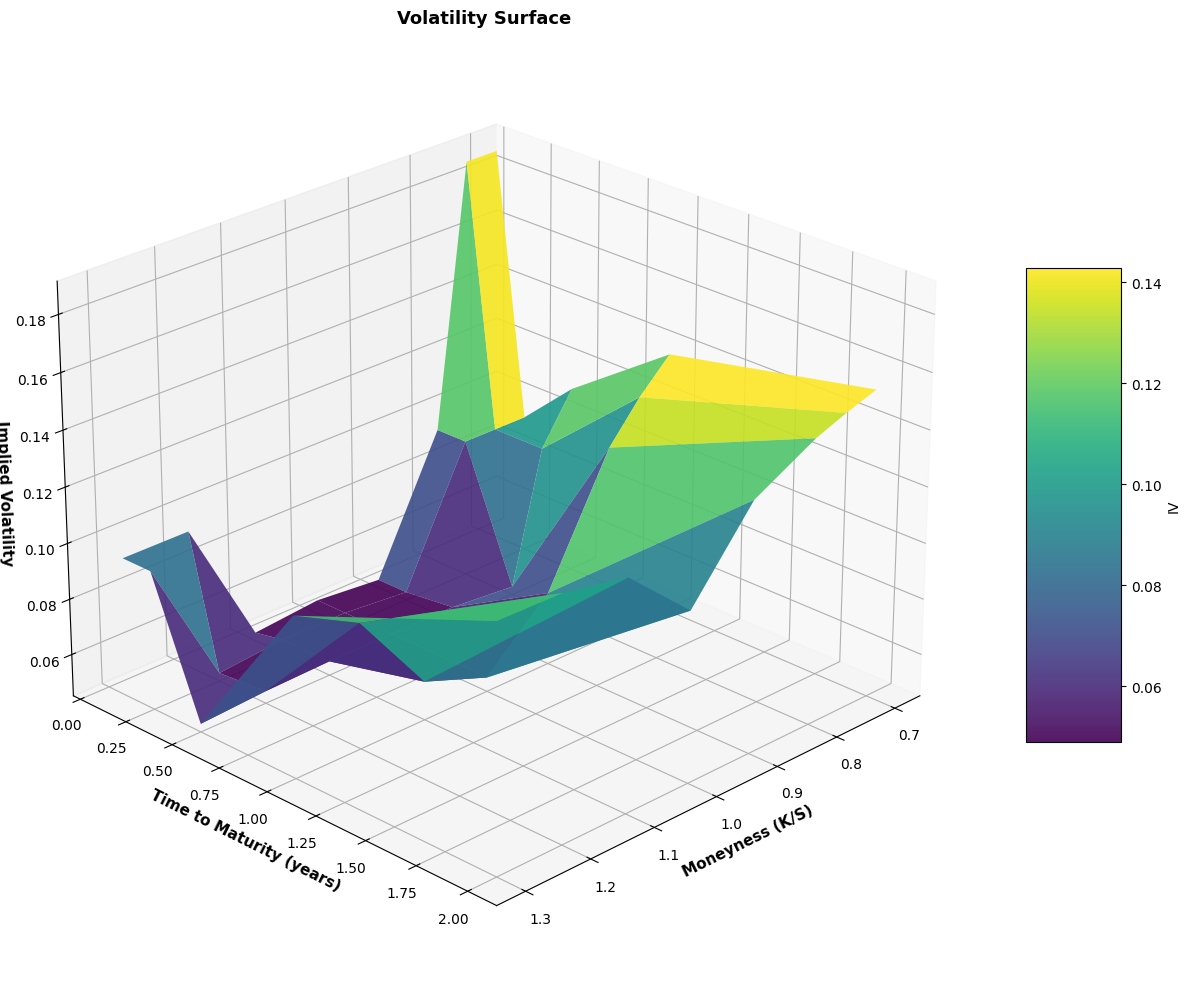

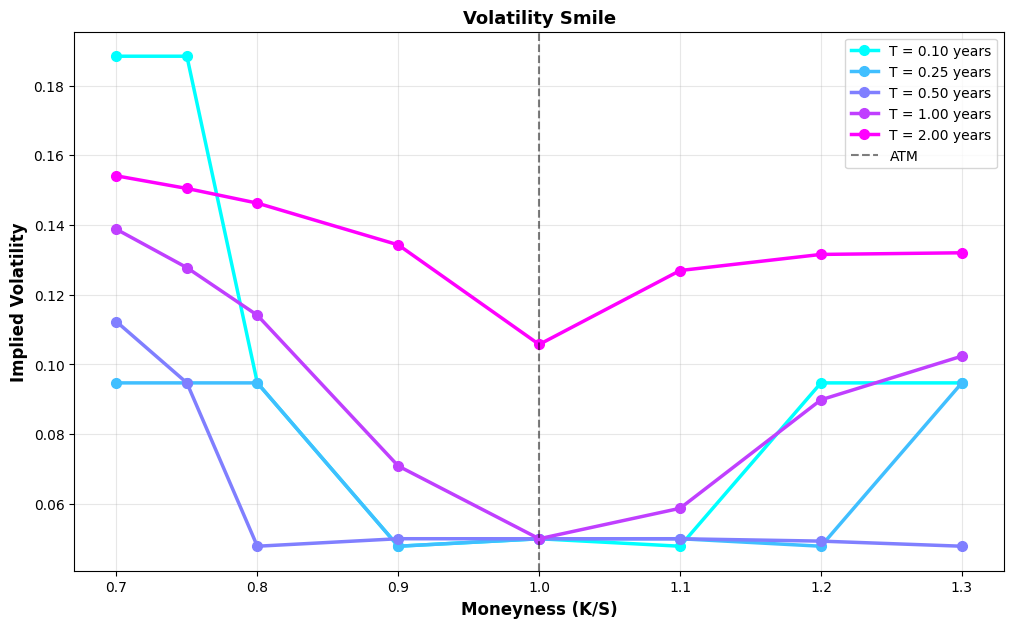

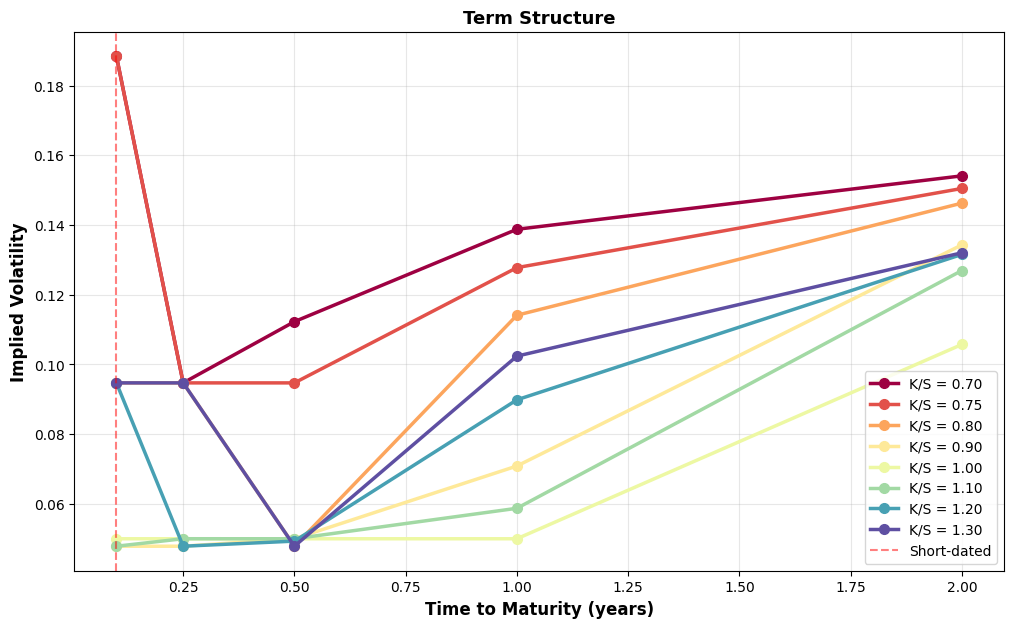

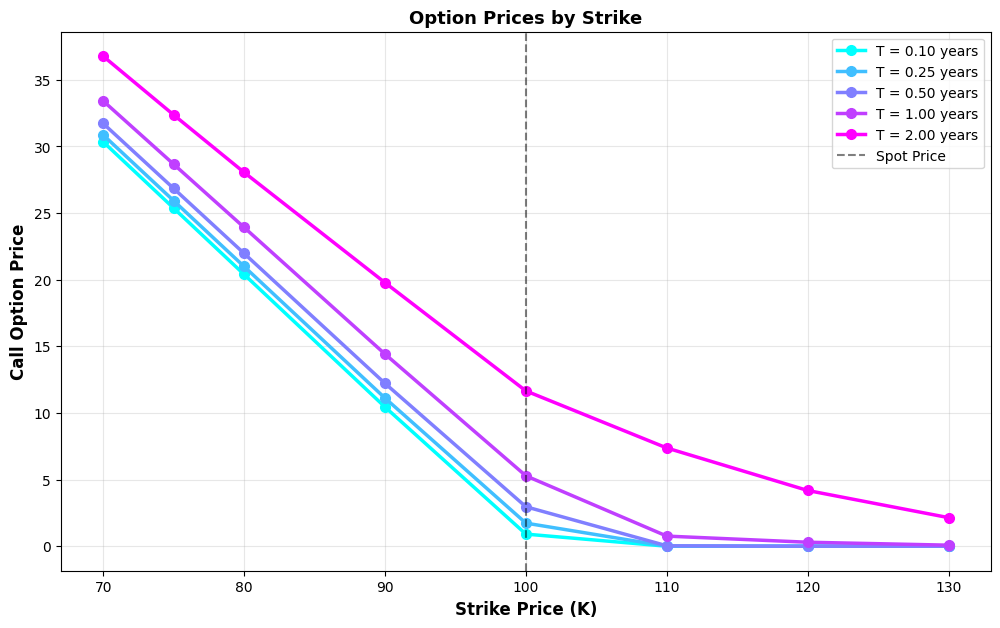

In [15]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Complete volatility surface workflow."""
    
    print("=" * 70)
    print("VOLATILITY SURFACE UNDER BLACK-SCHOLES FRAMEWORK")
    print("=" * 70)
    
    # Parameters
    S0 = 100  # Spot price
    r = 0.05  # Risk-free rate
    
    strikes = np.array([70, 75, 80, 90, 100, 110, 120, 130])
    maturities = np.array([0.1, 0.25, 0.5, 1.0, 2.0])
    
    print("\n[STEP 1] Generating Synthetic Market...")
    print(f"  Spot Price: {S0}")
    print(f"  Risk-free Rate: {r:.2%}")
    print(f"  Strikes: {strikes}")
    print(f"  Maturities: {maturities}")
    
    # Generate synthetic market
    prices, sigmas_true, strikes, maturities = generate_synthetic_market(
        S0=S0, strikes=strikes, maturities=maturities, r=r
    )
    
    print("\n[STEP 2] Extracting Implied Volatilities (Bisection Method)...")
    iv_grid = extract_implied_volatility_grid(prices, S0, strikes, maturities, r)
    print(f"  âœ“ Extracted {iv_grid.size} implied volatilities")
    
    # Validation: repricing errors
    repriced_prices = np.zeros_like(prices)
    errors = []
    for i, K in enumerate(strikes):
        for j, T in enumerate(maturities):
            repriced_prices[i, j] = black_scholes_call(S0, K, T, r, iv_grid[i, j])
            error = abs(repriced_prices[i, j] - prices[i, j])
            errors.append(error)
    
    max_error = np.max(errors)
    mean_error = np.mean(errors)
    print(f"  Repricing Error (Max): {max_error:.2e}")
    print(f"  Repricing Error (Mean): {mean_error:.2e}")
    
    print("\n[STEP 3] Fitting Volatility Surface (2D Spline)...")
    spline, moneyness = fit_volatility_surface(strikes, maturities, iv_grid, S0)
    print("  âœ“ Surface fitted successfully")
    
    print("\n[STEP 4] Summary Statistics...")
    print(f"  True Volatility - Mean: {sigmas_true.mean():.2%}, Std: {sigmas_true.std():.2%}")
    print(f"  Implied Volatility - Mean: {iv_grid.mean():.2%}, Std: {iv_grid.std():.2%}")
    
    print("\n[STEP 5] Creating Visualizations...")
    
    # 3D Surface
    fig1 = plot_volatility_surface_3d(strikes, maturities, iv_grid, S0)
    plt.savefig('volatility_surface_3d.png', dpi=150, bbox_inches='tight')
    print("  âœ“ Saved: volatility_surface_3d.png")
    
    # Volatility Smile
    fig2 = plot_volatility_smile(strikes, iv_grid, maturities, S0)
    plt.savefig('volatility_smile.png', dpi=150, bbox_inches='tight')
    print("  âœ“ Saved: volatility_smile.png")
    
    # Term Structure
    fig3 = plot_term_structure(maturities, iv_grid, strikes, S0)
    plt.savefig('volatility_term_structure.png', dpi=150, bbox_inches='tight')
    print("  âœ“ Saved: volatility_term_structure.png")
    
    # Option Prices
    fig4 = plot_option_prices_2d(S0, strikes, maturities, iv_grid, r)
    plt.savefig('option_prices_2d.png', dpi=150, bbox_inches='tight')
    print("  âœ“ Saved: option_prices_2d.png")
    
    print("\n[STEP 6] Summary Table...")
    df = create_summary_table(strikes, maturities, iv_grid, S0)
    print(df.to_string(index=False))
    
    print("\n" + "=" * 70)
    print("ANALYSIS COMPLETE")
    print("=" * 70)
    
    plt.show()


if __name__ == "__main__":
    main()